# Putting Homes On a Slope
Mason Sherbondy

2021.12.13

##  Goals
The goals of this project are to construct a machine learning Regression model that predicts tax assessed values of single-family properties that had a transaction during 2017 using their attributes and to determine key drivers of said values and to make recommendations on what does and/ or does not work for home value predictions.

## Initial Questions
1. Are properties concentrated in any one county?
2. Are houses priced higher on average in one county over another?
3. Why do some properties have a much higher value than others when they are located so close to each other?
4. Is having one bathroom worse than having two bedrooms?

## Data Dictionary
| Feature           | Datatype                   | Description                                               |
|:------------------|:---------------------------|:----------------------------------------------------------|
| parcel_id         | index (object)             | Numeric ID unique to each property                        |
| fips_id           | 45611 non-null: int64      | Federal Information Processing number (county)            |
| zip_code          | 45611 non-null: int64      | Zip code (generalized location)                           |
| bathroom_count    | 45611 non-null: float64    | Number of bathrooms on the property                       |
| bedroom_count     | 45611 non-null: float64    | Number of bedrooms on the property                        |
| square_footage    | 45611 non-null: float64    | Total square feet of the property                         |
| tax_value         | 45611 non-null: float64    | Tax assessed home value                                   |

In [1]:
#imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import mason_functions as mf

import os
import warnings
warnings.filterwarnings('ignore')

import sklearn.preprocessing
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import SelectKBest, f_regression, RFE

import wrangle
import explore
import evaluate

## Wrangle

In [2]:
#wrangle data
df = wrangle.clean_zillow_nadir()
train, validate, test = wrangle.prep_zillow_nadir()

In [3]:
df.head()

,fips_id,zip_code,bathroom_count,bedroom_count,square_footage,tax_value
parcel_id,,,,,,
14297519,6059,96978,3.5,4.0,3100.0,1023282.0
17052889,6111,97099,1.0,2.0,1465.0,464000.0
14186244,6059,97078,2.0,3.0,1243.0,564778.0
12177905,6037,96330,3.0,4.0,2376.0,145143.0
12095076,6037,96293,3.0,4.0,2962.0,773303.0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 45611 entries, 14297519 to 13083743
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   fips_id         45611 non-null  int64  
 1   zip_code        45611 non-null  int64  
 2   bathroom_count  45611 non-null  float64
 3   bedroom_count   45611 non-null  float64
 4   square_footage  45611 non-null  float64
 5   tax_value       45611 non-null  float64
dtypes: float64(4), int64(2)
memory usage: 2.4 MB


## Explore

In [5]:
#define numeric columns
quant_vars = ['bathroom_count', 'bedroom_count', 'square_footage', 'tax_value']

       fips_id zip_code bathroom_count bedroom_count square_footage  tax_value
count    45611    45611          45611         45611          45611      45611
mean   6049.11  96623.1        2.10491       3.21265        1705.44     373171
std    21.1491  3778.18       0.728925      0.789769        613.051     244586
min       6037    95982              1             2            152       1000
25%       6037    96213              2             3           1242     174444
50%       6037    96424              2             3           1574     336932
75%       6059    97003            2.5             4           2069     522062
max       6111   399675              4             5           3566  1.124e+06


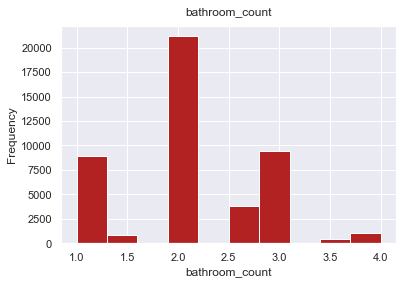

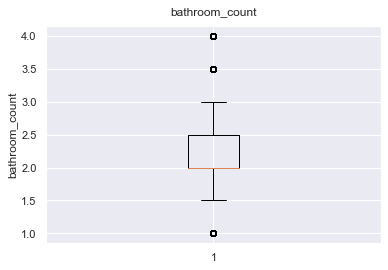

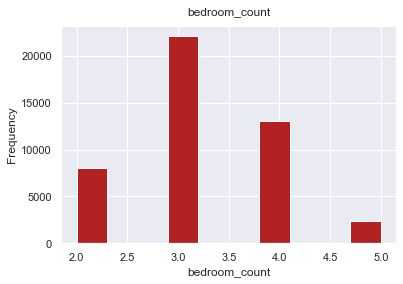

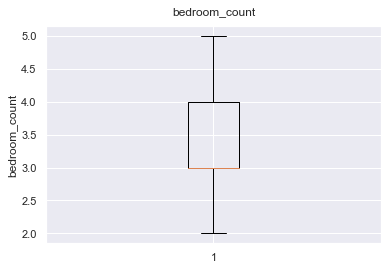

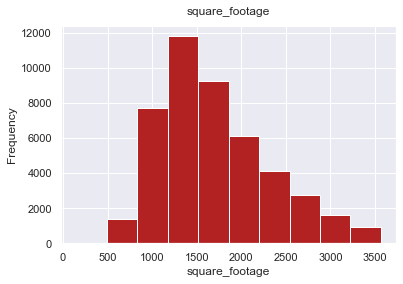

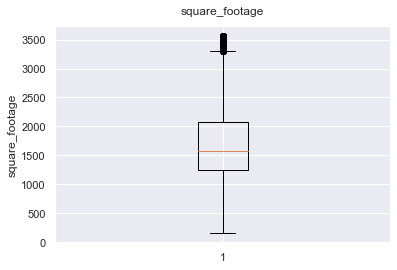

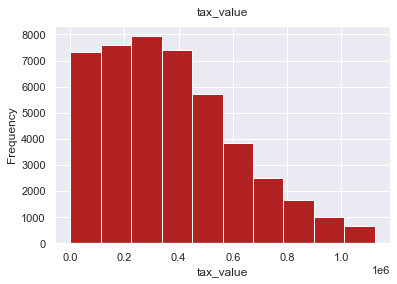

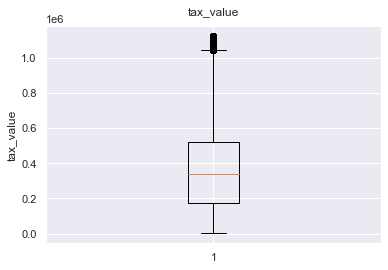

<Figure size 432x288 with 0 Axes>

In [6]:
#distributions
sns.set()
print(df.describe().apply(lambda s: s.apply(lambda x: format(x, 'g'))))
for cat in quant_vars:
    df[cat].hist(color = 'firebrick')
    plt.title(cat, pad = 11)
    plt.xlabel(cat)
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show();
    plt.boxplot(df[cat])
    plt.title(cat, pad = 11)
    plt.ylabel(cat)
    plt.grid(True)
    plt.show()
    plt.tight_layout();

### Are properties focused in any one county?

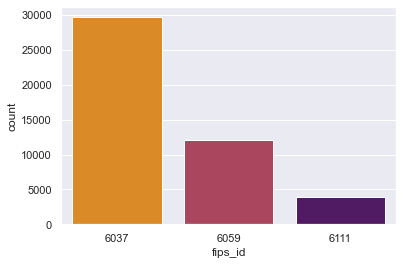

In [7]:
#view distribution across counties
sns.countplot(x = 'fips_id', data = df, palette = 'inferno_r');

Yes, LA County seems to be a source of focus.

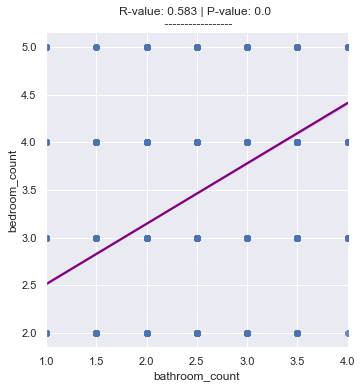

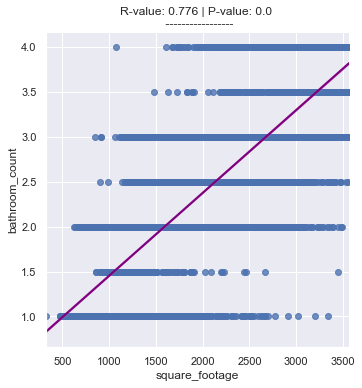

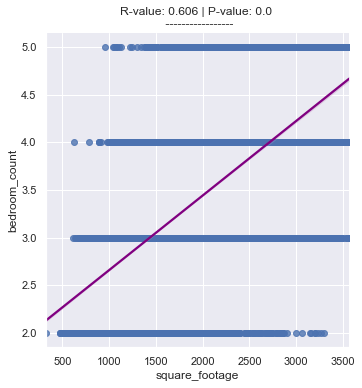

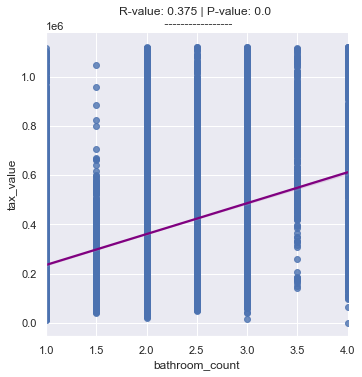

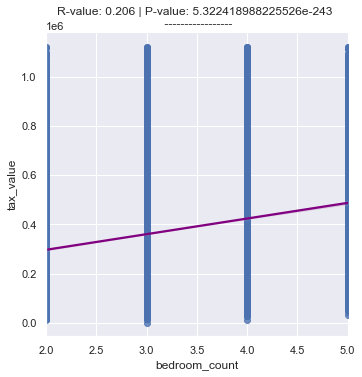

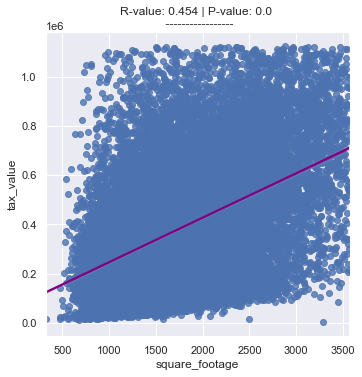

In [8]:
#visualize linear correlations between variables
explore.plot_variable_pairs(train)

### Takeaways
* square footage correlates most with the target variable with a correlation coefficient of .454
* bathroom count comes in second place with .375
* bedroom count comes in third (last) with .206

### Are houses priced higher on average in one county over another?

In [9]:
#assign variables to respective data
los_angeles_county = train[train.fips_id == 6037]
orange_county = train[train.fips_id == 6059]
ventura_county = train[train.fips_id == 6111]

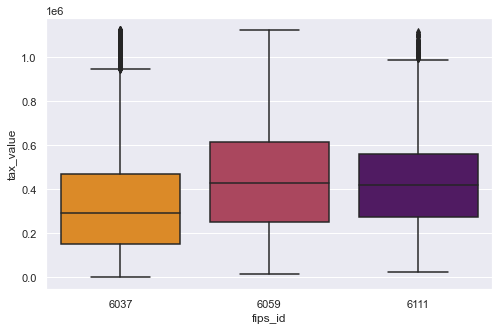

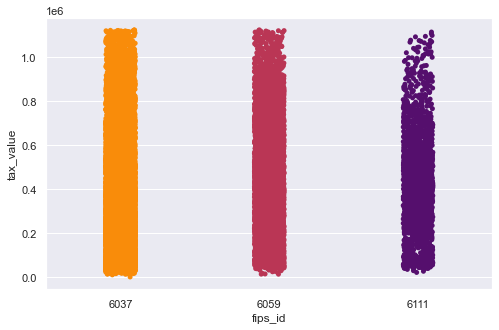

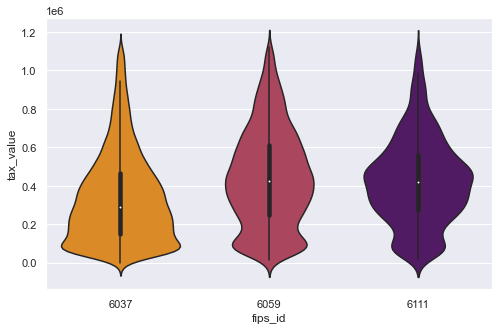

In [10]:
#target variable visualized across counties
explore.plot_categorical_and_continuous(train, 'fips_id', 'tax_value')

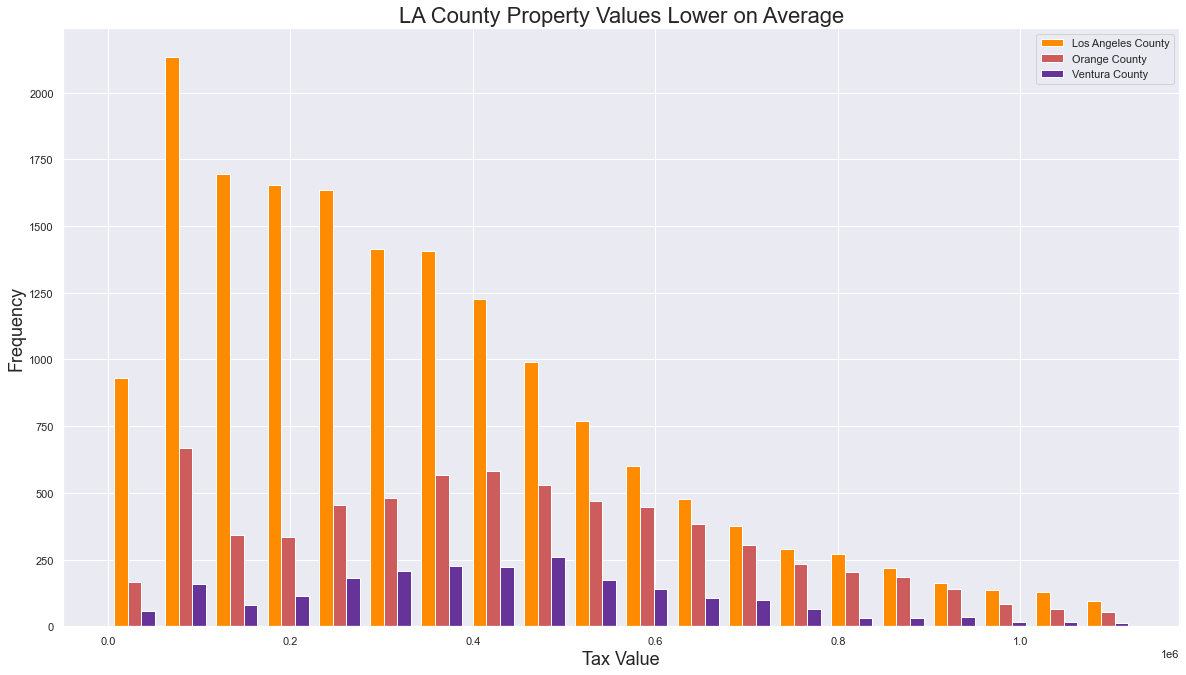

In [11]:
#visualize target variable across different counties
plt.figure(figsize = (20, 11))
plt.hist([los_angeles_county.tax_value, orange_county.tax_value, ventura_county.tax_value],
         label = ['Los Angeles County', 'Orange County', 'Ventura County'],
         color = ['darkorange', 'indianred', 'rebeccapurple'],
         bins = 20
        )
plt.legend()
plt.title('LA County Property Values Lower on Average', size = 22, pad = 6)
plt.xlabel('Tax Value', size = 18)
plt.ylabel('Frequency', size = 18);

The charts show that LA County's average home values are definitely lower than the other two counties, but what about the other two counties? Let's run a stats test to see if Orange County has a signficantly higher average.

* Null hypothesis: Properties in Orange County have the same value as those in Ventura County.
* Alternate hypothesis: Properties in Orange County have higher value than those in Ventura County.

In [12]:
#variances at a glance
orange_county.tax_value.var(), ventura_county.tax_value.var()

(64591136619.10142, 49957492788.22059)

In [13]:
#low p-value indicates these variances are indeed different
stats.levene(orange_county.tax_value, ventura_county.tax_value)

LeveneResult(statistic=75.06457355832937, pvalue=5.351826473960582e-18)

In [14]:
#run the test, distributions seem normal enough (we have plenty of observations)
stats.ttest_ind(orange_county.tax_value, ventura_county.tax_value, equal_var = False, alternative = 'greater')

Ttest_indResult(statistic=2.978438384410036, pvalue=0.0014567236918552975)

With such a low p-value and positive t-statistic, I can say with 99% confidence that I reject the null hypothesis that home values in Orange County are the same as those in Ventura County.

### Takeaways
* Orange County houses are priced higher on average
* LA County houses are priced lower on average

### Why do some properties have a much higher value than others when they are located so close to each other?

In [15]:
#let's dive into a zip code
zip_97319 = train[train.zip_code == 97319]

223614.58611825193

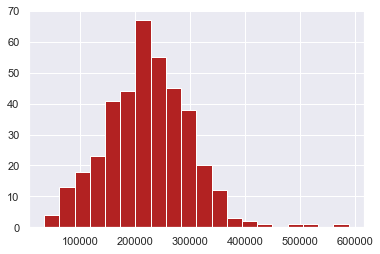

In [16]:
#visualize distribution of home values in this area
zip_97319.tax_value.hist(bins = 20, color = 'firebrick');
#what is the average home value for properties located in zip code 97319?
zip_97319.tax_value.mean()

In [17]:
#assign variables to: homes with an above-average home value and homes with a below-average home value
zip_97319_above_average = zip_97319[zip_97319.tax_value > zip_97319.tax_value.mean()]
zip_97319_below_average = zip_97319[zip_97319.tax_value < zip_97319.tax_value.mean()]

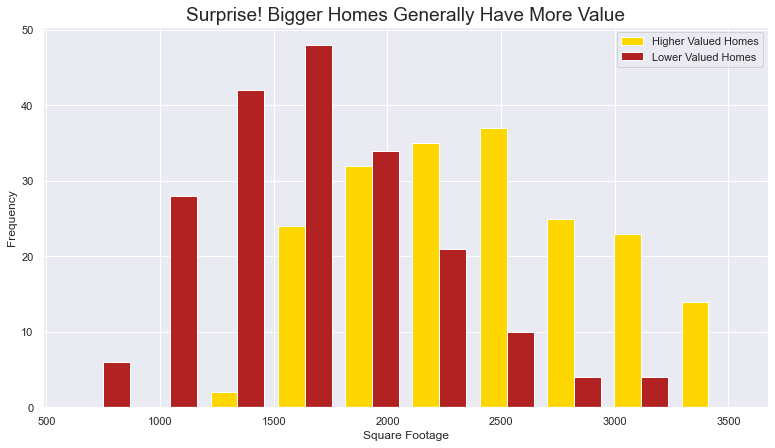

In [18]:
#Is it just the size of the house?
plt.figure(figsize = (13, 7))
plt.hist([zip_97319_above_average.square_footage, zip_97319_below_average.square_footage],
        label = ['Higher Valued Homes', 'Lower Valued Homes'],
        color = ['gold', 'firebrick']
        )
plt.xlabel('Square Footage')
plt.ylabel('Frequency')
plt.title('Surprise! Bigger Homes Generally Have More Value', size = 19)
plt.legend();

### Takeaways
* Homes in the same zip are priced higher because the homes are bigger

### Is having one bathroom worse than having two bedrooms?

In [19]:
#assign variables to respective data
one_bath = train[train.bathroom_count == 1]
two_bed = train[train.bedroom_count == 2]

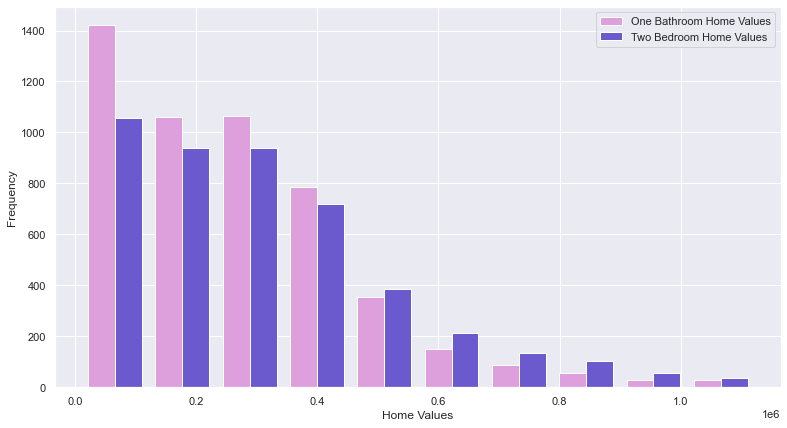

In [20]:
#visualize property values for homes with one bathroom vs homes with two bedrooms
plt.figure(figsize = (13, 7))
plt.hist([one_bath.tax_value, two_bed.tax_value],
        label = ['One Bathroom Home Values', 'Two Bedroom Home Values'],
        color = ['plum', 'slateblue']
        )
plt.xlabel('Home Values')
plt.ylabel('Frequency')
plt.legend();

It is not crystal clear to me from the charts which subset of homes has higher values, but I'm leaning toward two-bedroom houses. Let's run a statistical test.

* Null hypothesis: Property values for two-bedroom homes are less than or the same as those for one-bathroom homes.
* Alternate hypothesis: Property values for two-bedroom homes are more than those with one-bathroom homes. 

In [21]:
#variances at a glance
one_bath.tax_value.var(), two_bed.tax_value.var()

(38226796595.87816, 48130026149.11671)

In [22]:
#under the scope
stats.levene(one_bath.tax_value, two_bed.tax_value)
#low p-value indicates different variances

LeveneResult(statistic=41.61584772164236, pvalue=1.1643946173022903e-10)

In [23]:
#let's run a T-test with equal_var set to False
stats.ttest_ind(two_bed.tax_value, one_bath.tax_value, equal_var = False, alternative = 'greater')

Ttest_indResult(statistic=9.349021186396701, pvalue=5.460608715708539e-21)

I can with 99% confidence reject the null hypothesis that proprety values for two-bedroom homes are the same as or less than those with one-bathroom homes.

### Takeaways
* two-bedroom homes have on average higher property values than property values of one-bathroom homes
* having two bedrooms is worse-- if worse means having a higher property value

## Modeling

In [24]:
#no need to scale target variable
quant_vars.remove('tax_value')

In [25]:
#create object
scaler = sklearn.preprocessing.RobustScaler()

#fit object
scaler.fit(train[quant_vars])

#transform data
train_scaled = scaler.transform(train[quant_vars])
validate_scaled = scaler.transform(validate[quant_vars])
test_scaled = scaler.transform(test[quant_vars])

In [26]:
#assign new columns
train[['bathroom_count_scaled', 'bedroom_count_scaled', 'square_footage_scaled']] = train_scaled
validate[['bathroom_count_scaled', 'bedroom_count_scaled', 'square_footage_scaled']] = validate_scaled
test[['bathroom_count_scaled', 'bedroom_count_scaled', 'square_footage_scaled']] = test_scaled

In [27]:
scaled = ['bathroom_count_scaled', 'bedroom_count_scaled', 'square_footage_scaled']

In [28]:
#set up modeling data
X_train = train[scaled]
y_train = train.tax_value

X_validate = validate[scaled]
y_validate = validate.tax_value

X_test = test[scaled]
y_test = test.tax_value

In [29]:
#set a baseline
train['baseline'] = train.tax_value.mean()
baseline = train.tax_value.mean()

In [30]:
#let's
ols_III = LinearRegression(normalize = True)

#fit it
ols_III.fit(X_train, y_train)

#predict
train['y_hatIII'] = ols_III.predict(X_train)

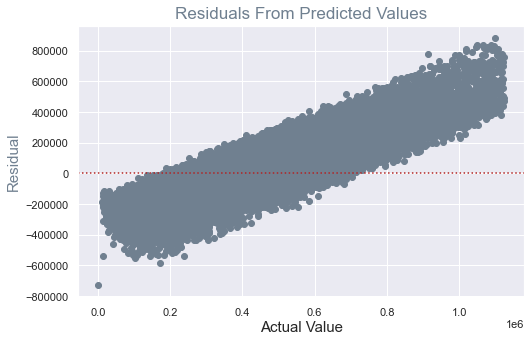

In [31]:
evaluate.plot_residuals(y_train, train.y_hatIII)

In [32]:
evaluate.regression_errors(y_train, train.y_hatIII)

Model Metrics


SSE     1.201146e+15
ESS     3.324524e+14
TSS     1.533599e+15
MSE     4.702816e+10
RMSE    2.168598e+05
dtype: float64

In [33]:
#predict home values on validate set
validate['y_hat'] = ols_III.predict(X_validate)

In [34]:
#compare results
evaluate.compare_train_validate_errors(y_train, y_validate, train.y_hatIII, validate.y_hat)

Train RMSE: 216859.77
Validate RMSE: 216879.49
Difference: 19.72


In [35]:
#let's try another model

#creation
lars = sklearn.linear_model.LassoLars(alpha = 1)

#fitting
lars.fit(X_train, y_train)

#predicting
train['y_hatIV'] = lars.predict(X_train)

In [36]:
evaluate.regression_errors(y_train, train.y_hatIV)

Model Metrics


SSE     1.201150e+15
ESS     3.311043e+14
TSS     1.532254e+15
MSE     4.702831e+10
RMSE    2.168601e+05
dtype: float64

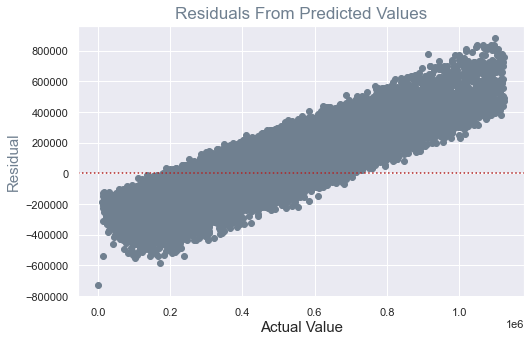

In [37]:
evaluate.plot_residuals(y_train, train.y_hatIV)

In [38]:
#let's try this model on the validate set

#predict
validate['y_hatII'] = lars.predict(X_validate)

#compare models
evaluate.compare_train_validate_errors(y_train, y_validate, train.y_hatIV, validate.y_hatII)

Train RMSE: 216860.11
Validate RMSE: 216878.77
Difference: 18.66


In [39]:
#let's try a different model

#create
glmII = sklearn.linear_model.TweedieRegressor(power = 1, alpha = .1)

#fit it
glmII.fit(X_train, y_train)

#predict
train['y_hatVIII'] = glmII.predict(X_train)

In [40]:
evaluate.regression_errors(y_train, train.y_hatVIII)

Model Metrics


SSE     1.204713e+15
ESS     3.417487e+14
TSS     1.546462e+15
MSE     4.716783e+10
RMSE    2.171816e+05
dtype: float64

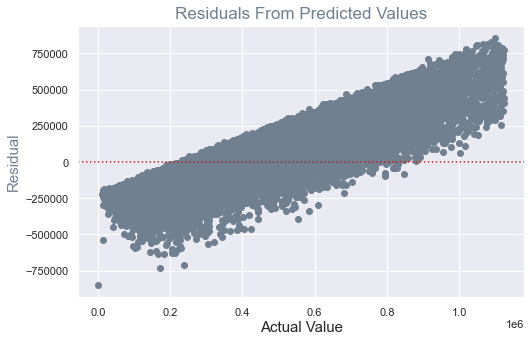

In [41]:
evaluate.plot_residuals(y_train, train.y_hatVIII)

In [42]:
#predict
validate['y_hatIII'] = glmII.predict(X_validate)

In [43]:
evaluate.regression_errors(y_validate, validate.y_hatIII)

Model Metrics


SSE     5.162561e+14
ESS     1.442493e+14
TSS     6.605055e+14
MSE     4.715960e+10
RMSE    2.171626e+05
dtype: float64

In [44]:
evaluate.compare_train_validate_errors(y_train, y_validate, train.y_hatVIII, validate.y_hatIII)

Train RMSE: 217181.55
Validate RMSE: 217162.61
Difference: -18.94


Getting preetty similar errors, but my best OLS model has a lesser error while virtually the same amount of difference. Let's test my best model

In [45]:
#predict
test['y_hat'] = ols_III.predict(X_test)

In [46]:
evaluate.regression_errors(y_test, test.y_hat)

Model Metrics


SSE     4.383166e+14
ESS     1.190228e+14
TSS     5.573394e+14
MSE     4.804523e+10
RMSE    2.191922e+05
dtype: float64

In [47]:
evaluate.baseline_mean_errors(y_test)

Baseline Metrics
----------------


SSE     5.495710e+14
MSE     6.024017e+10
RMSE    2.454387e+05
dtype: float64

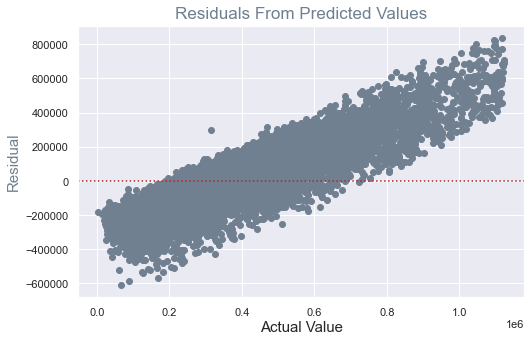

In [48]:
evaluate.plot_residuals(y_test, test.y_hat)

### Conclusion
* you cannot get away with estimating a house's value based solely on square footage, bathroom and bedroom counts with this range of values

* my best linear model has an average error of 219K USD-- this model does not seem useful at all to me

* my models all beat a baseline model that uses the mean of all values to predict home values